In [105]:
%reload_ext autoreload
%autoreload 2

from agama_spray import *
from utils import *
from models_streams import *

In [106]:
params = [
    1.331894490855406588e+01,
    2.441091252550232582e+01,
    9.783571786742331078e-01,
    8.830960963814488140e-01,
    1.875641070271489019e-01,
    9.683001634771329913e-01,
    8.012867222690761793e+00,
    2.037439625282703393e+00,
    9.089267564398808474e+01,
    3.578894919126337726e+01,
    4.226245547900189337e+01,
    2.926375566231026681e+00,
    4.147323622050326231e-01,
    -3.735887079750737638e-01,
    7.304075075100886494e-01,
    5.421078379317691542e+00
]


In [122]:
logM, Rs, q, dirx, diry, dirz, logm, rs, pos_init_x, pos_init_y, pos_init_z, logv, dirvx, dirvy, dirvz, time_total = params

rot_mat = get_mat(dirx, diry, dirz)
rot = R.from_matrix(rot_mat)
euler_angles = rot.as_euler('xyz', degrees=False)

densitynorm = compute_densitynorm(10**logM, Rs, q)
pot_host = agama.Potential(type='Spheroid', densitynorm=densitynorm, scaleradius=Rs, gamma=1, alpha=1, beta=3, 
                            axisRatioY=1, axisRatioZ=q, orientation=euler_angles)

num_particles = int(1e4)  # number of particles in the stream

v_dir = np.array([dirvx, dirvy, dirvz])
v_dir = v_dir/np.linalg.norm(v_dir)
vx = 10**logv * v_dir[0]
vy = 10**logv * v_dir[1]
vz = 10**logv * v_dir[2]

posvel_sat = np.array([pos_init_x, pos_init_y, pos_init_z, vx, vy, vz])

stream, xyz_orbit, time_orbit = create_stream_particle_spray_with_progenitor(time_total, num_particles, pot_host, posvel_sat, 10**logm, rs, gala_modified=True)


In [123]:
time_stream = np.stack(stream[:, 0])
xyz_stream = np.stack(stream[:, 1])[..., :3]

In [144]:
from scipy.interpolate import CubicSpline

x_orbit = xyz_orbit[:, 0]
y_orbit = xyz_orbit[:, 1]
z_orbit = xyz_orbit[:, 2]
r_orbit = np.sqrt(x_orbit**2 + y_orbit**2 + z_orbit**2)

x_stream = xyz_stream[:, -1, 0]
y_stream = xyz_stream[:, -1, 1]
z_stream = xyz_stream[:, -1, 2]
r_stream = np.sqrt(x_stream**2 + y_stream**2) #+ z_stream**2)

x_spline = CubicSpline(time_orbit, x_orbit)
y_spline = CubicSpline(time_orbit, y_orbit)
z_spline = CubicSpline(time_orbit, z_orbit)
r_spline = CubicSpline(time_orbit, r_orbit)

In [145]:
r_prog_at_time = r_spline(time_stream)

all_r_stream = np.linalg.norm(xyz_stream, axis=-1)

gamma = np.sum(all_r_stream - r_prog_at_time, axis=-1)
gamma_min = np.min(gamma)
gamma_max = np.max(gamma)
gamma = 2 * (gamma - gamma_min) / (gamma_max - gamma_min) - 1

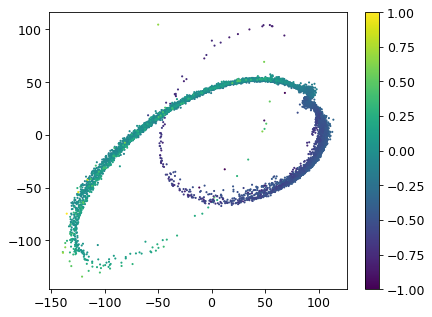

In [146]:
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='viridis')

plt.colorbar()

/data/dc824-2/Astro/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/data/dc824-2/Astro/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


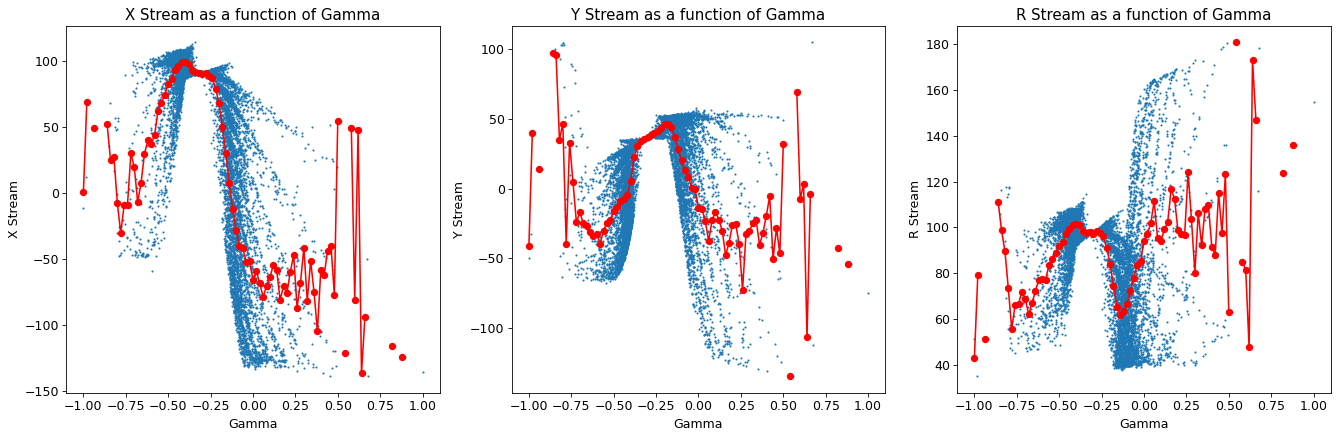

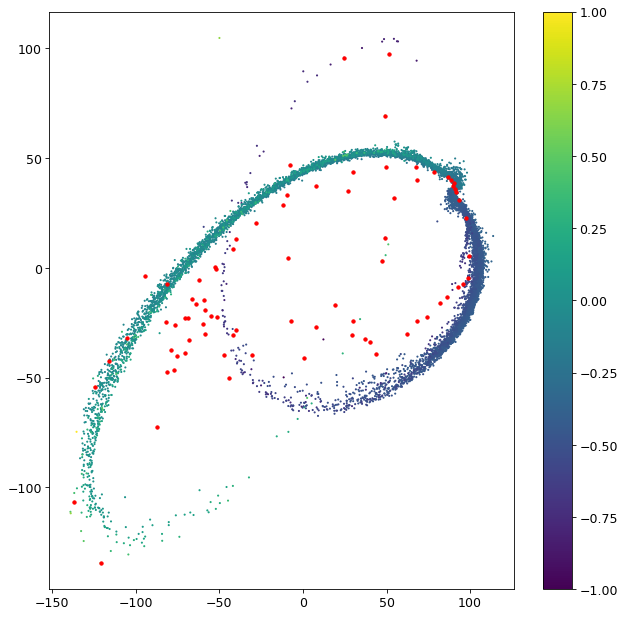

In [150]:
# Define the number of bins
num_bins = 100
uniform = 'linear'

if uniform == 'linear':
    # Compute the bin edges such that each bin has a constant size
    bin_edges = np.linspace(np.min(gamma), np.max(gamma), num_bins + 1)
elif uniform == 'count':
    # Compute the bin edges such that each bin has an equal number of points
    bin_edges = np.percentile(gamma, np.linspace(0, 100, num_bins + 1))

# Bin the gamma values
indices = np.digitize(gamma, bin_edges)

# Compute the average x_stream and y_stream in each bin
average_x_in_bins = [np.mean(x_stream[indices == i]) for i in range(1, num_bins + 1)]
average_y_in_bins = [np.mean(y_stream[indices == i]) for i in range(1, num_bins + 1)]
average_r_in_bins = [np.mean(r_stream[indices == i]) for i in range(1, num_bins + 1)]

plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.scatter(gamma, x_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_x_in_bins, 'ro-')
plt.xlabel('Gamma')
plt.ylabel('X Stream')
plt.title('X Stream as a function of Gamma')

plt.subplot(1, 3, 2)
plt.scatter(gamma, y_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_y_in_bins, 'ro-')
plt.xlabel('Gamma')
plt.ylabel('Y Stream')
plt.title('Y Stream as a function of Gamma')

plt.subplot(1, 3, 3)
plt.scatter(gamma, r_stream, color='tab:blue', s=1)
plt.plot(bin_edges[:-1], average_r_in_bins, 'ro-')
plt.xlabel('Gamma')
plt.ylabel('R Stream')
plt.title('R Stream as a function of Gamma')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 10))
plt.scatter(xyz_stream[:, -1, 0], xyz_stream[:, -1, 1], s=1, c=gamma, cmap='viridis')
plt.colorbar()
plt.scatter(average_x_in_bins, average_y_in_bins, c='r', s=10)